# Get metrics and Plot

In [ ]:
import matplotlib.pyplot as plt
from train import *

In [17]:
SFNP_path = "logs/SFNP_train_seed0_lr0.000168_bs_1_Tue Feb 28 01:09:51 2023"

In [46]:
class Evaluator():
    def __init__(self, dirpath, Model):
        self.dirpath = dirpath
        self.config = yaml.safe_load(open(f"{dirpath}/saved_config.yaml"))
        self.init_dataloader()
        self.Model = Model
        self.init_model()

    def init_model(self):
        self.device = torch.device('cuda')
        model_dict = torch.load(f"{self.dirpath}/best.pt", map_location=torch.device('cuda'))
        model = self.Model(model_dict['config']['model']).to(self.device)

        model.load_state_dict(model_dict['model'])
        model.eval()
        self.model = model

    def init_dataloader(self):
        l2_x_data = sorted(glob.glob(f"{self.config['data_dir']}/SPCAM5/inputs_*"), key=sort_fn)
        l2_y_data = sorted(glob.glob(f"{self.config['data_dir']}/SPCAM5/outputs_*"), key=sort_fn)
        l1_x_data = sorted(glob.glob(f"{self.config['data_dir']}/CAM5/inputs_*"), key=sort_fn)
        l1_y_data = sorted(glob.glob(f"{self.config['data_dir']}/CAM5/outputs_*"), key=sort_fn)

        n = int(365*0.8)
        self.l2_x_train = l2_x_data[:n]
        self.l2_y_train = l2_y_data[:n]
        self.l2_x_valid = l2_x_data[n:365]
        self.l2_y_valid = l2_y_data[n:365]
        self.l2_x_test = l2_x_data[365:]
        self.l2_y_test = l2_y_data[365:]
        self.l1_x_train = l1_x_data[:n]
        self.l1_y_train = l1_y_data[:n]
        self.l1_x_valid = l1_x_data[n:365]
        self.l1_y_valid = l1_y_data[n:365]
        self.l1_x_test = l1_x_data[365:]
        self.l1_y_test = l1_y_data[365:]
        l1_x_scaler_minmax = dill.load(open(f"../../scalers/x_CAM5_minmax_scaler.dill", 'rb'))
        l1_y_scaler_minmax = dill.load(open(f"../../scalers/y_CAM5_minmax_scaler.dill", 'rb'))

        l2_x_scaler_minmax = dill.load(open(f"../../scalers/x_SPCAM5_minmax_scaler.dill", 'rb'))
        l2_y_scaler_minmax = dill.load(open(f"../../scalers/y_SPCAM5_minmax_scaler.dill", 'rb'))

        # Change to first 26 variables
        l2_y_scaler_minmax.min = l2_y_scaler_minmax.min[:26]
        l2_y_scaler_minmax.max = l2_y_scaler_minmax.max[:26]
        l1_y_scaler_minmax.min = l1_y_scaler_minmax.min[:26]
        l1_y_scaler_minmax.max = l1_y_scaler_minmax.max[:26]

        if self.model_type != "multi":
            trainset = l2Dataset(self.l2_x_train, self.l2_y_train, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
            self.trainloader = DataLoader(trainset, batch_size=self.config['batch_size'], shuffle=True, drop_last=False, \
                                            num_workers=4, pin_memory=True)
            validset = l2Dataset(self.l2_x_valid, self.l2_y_valid, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
            self.validloader = DataLoader(validset, batch_size=self.config['batch_size'], shuffle=False, drop_last=False, \
                                            num_workers=4, pin_memory=True)
            testset = l2Dataset(self.l2_x_test, self.l2_y_test, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
            self.testloader = DataLoader(testset, batch_size=self.config['batch_size'], shuffle=False, drop_last=False, \
                                        num_workers=4, pin_memory=True)
        else:
            trainset = MutliDataset(self.l1_x_train, self.l1_y_train, self.l2_x_train, self.l2_y_train,
                                            l1_x_scaler=l1_x_scaler_minmax, l1_y_scaler=l1_y_scaler_minmax,
                                            l2_x_scaler=l2_x_scaler_minmax, l2_y_scaler=l2_y_scaler_minmax, nested=self.config['nested'], variables=[26, 26])
            self.trainloader = DataLoader(trainset, self.config['batch_size'], shuffle=True, drop_last=False, num_workers=0, pin_memory=True)

            validset = MutliDataset(self.l1_x_valid, self.l1_y_valid, self.l2_x_valid, self.l2_y_valid,
                                    l1_x_scaler=l1_x_scaler_minmax, l1_y_scaler=l1_y_scaler_minmax,
                                    l2_x_scaler=l2_x_scaler_minmax, l2_y_scaler=l2_y_scaler_minmax, nested=self.config['nested'], variables=[26, 26])
            self.validloader = DataLoader(validset, self.config['batch_size'], shuffle=False, drop_last=False, num_workers=0, pin_memory=True)
            testset = MutliDataset(self.l1_x_test, self.l1_y_test, self.l2_x_test, self.l2_y_test, l1_x_scaler=l1_x_scaler_minmax, l1_y_scaler=l1_y_scaler_minmax, nested=self.config['nested'], variables=[26, 26])
            self.testloader = DataLoader(testset, self.config['batch_size'], shuffle=False, drop_last=False, num_workers=0, pin_memory=True)

        self.l2_y_scaler_minmax = l2_y_scaler_minmax

    def get_metrics(self, loader):
        self.get_R_stats(loader)
        self.r = self.ssxym / np.sqrt(self.ssxm * self.ssym)
        return self.non_mae, self.nmae, self.r

    def forward_pass(self, data):
        with torch.no_grad():
            if self.model_type == "multi":
                l1_x, l1_y, l2_x, l2_y = data
                l1_x = l1_x.reshape(-1, 1, l1_x.shape[-1]).to(device)
                l1_y = l1_y.reshape(-1, 1, l1_y.shape[-1]).to(device)
            else:
                l2_x, l2_y = data
                l2_x, l2_y = l2_x.to(device), l2_y.to(device)

            if self.model_type != "attentive":
                l2_x = l2_x.reshape(-1, 1, l2_x.shape[-1]).to(device)
                l2_y = l2_y.reshape(-1, 1, l2_y.shape[-1]).to(device)

            if self.model_type == "forward":
                l2_output_mu = self.model(l2_x)
                l2_truth = l2_y
            elif self.model_type == "multi":
                l1_output_mu, l1_output_cov, l2_output_mu, l2_output_cov, l1_y_truth,\
                    l2_truth, l1_z_mu_all, l1_z_cov_all, l1_z_mu_c, l1_z_cov_c, \
                    l2_z_mu_all, l2_z_cov_all, l2_z_mu_c, l2_z_cov_c = self.model(l1_x, l1_y, l2_x, l2_y)
            elif self.model_type == "attentive":
                mask, others = split_context_target(l2_x, l2_y, self.config['model']['context_percentage_low'], 
                                                                                self.config['model']['context_percentage_high'])
                context_x, context_y, target_x, l2_truth = l2_x[:, mask], l2_y[:, mask], l2_x[:, others], l2_y[:, others]
                l2_output_mu, l2_output_cov = self.model(context_x, context_y, target_x)
                self.mask = mask
            else:
                l2_output_mu, l2_output_cov, l2_truth, l2_z_mu_all, \
                        l2_z_cov_all, l2_z_mu_c, l2_z_cov_c = self.model(l2_x, l2_y)
            
            non_y_pred = self.l2_y_scaler_minmax.inverse_transform(l2_output_mu.squeeze().cpu().numpy())
            non_y = self.l2_y_scaler_minmax.inverse_transform(l2_truth.squeeze().cpu().numpy())
            return non_y, non_y_pred

    def get_R_stats(self, loader):
        self._get_stats(loader)
        self.ssxm = 0
        self.ssxym = 0
        self.ssym = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(loader, total=len(loader))):
                if self.model_type == "attentive":
                    n_mb = 9
                    data = [d[:, ::int(n_mb)] for d in data]

                    for b in range(n_mb): # Split into batches due to GPU limit
                        non_y, non_y_pred = self.forward_pass([d[:, b::n_mb] for d in data])

                        self.ssxm += ((non_y - self.y_mean)**2).sum(0)
                        self.ssym += ((non_y_pred - self.y_pred_mean)**2).sum(0)
                        self.ssxym += ((non_y - self.y_mean) * (non_y_pred - self.y_pred_mean)).sum(0)
                else:
                    non_y, non_y_pred = self.forward_pass(data)
                self.ssxm += ((non_y - self.y_mean)**2).sum(0)
                self.ssym += ((non_y_pred - self.y_pred_mean)**2).sum(0)
                self.ssxym += ((non_y - self.y_mean) * (non_y_pred - self.y_pred_mean)).sum(0)
            # Get average
            self.ssxm /= self.n_total
            self.ssym /= self.n_total
            self.ssxym /= self.n_total

    def _get_stats(self, loader):
        self.n_total = 0
        self.x_total = 0
        self.y_total = 0
        self.xy_total = 0
        self.x2_total = 0
        self.y2_total = 0
        self.y_mean = 0
        self.y_pred_mean = 0
        self.nmae = 0
        self.non_mae = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(loader, total=len(loader))):
                if self.model_type == "attentive":
                    n_mb = 9
                    data = [d[:, ::int(n_mb)] for d in data]
                    for b in range(n_mb): # Split into batches due to GPU limit
                        non_y, non_y_pred = self.forward_pass([d[:, b::n_mb] for d in data])
                        non_mae = mae_metric(non_y_pred, non_y, mean=False)

                        self.y_mean += non_y.sum(axis=0)
                        self.y_pred_mean += non_y_pred.sum(axis=0)
                        self.non_mae += non_mae.sum(axis=0)
                        self.n_total += non_y.shape[0]
                        self.x_total += non_y.sum(axis=0)
                        self.y_total += non_y_pred.sum(axis=0)
                        self.x2_total += (non_y ** 2).sum(axis=0)
                        self.y2_total += (non_y_pred ** 2).sum(axis=0)
                        self.xy_total += (non_y_pred * non_y).sum(axis=0)
                else:
                    non_y, non_y_pred = self.forward_pass(data)

                    non_mae = mae_metric(non_y_pred, non_y, mean=False)

                    self.y_mean += non_y.sum(axis=0)
                    self.y_pred_mean += non_y_pred.sum(axis=0)
                    self.non_mae += non_mae.sum(axis=0)
                    self.n_total += non_y.shape[0]
                    self.x_total += non_y.sum(axis=0)
                    self.y_total += non_y_pred.sum(axis=0)
                    self.x2_total += (non_y ** 2).sum(axis=0)
                    self.y2_total += (non_y_pred ** 2).sum(axis=0)
                    self.xy_total += (non_y_pred * non_y).sum(axis=0)

        self.y_mean /= self.n_total
        self.y_pred_mean /= self.n_total
        self.nmae /= self.n_total
        self.non_mae /= self.n_total
        self.nmae = np.abs(np.sqrt(self.non_mae / self.n_total) / np.abs(self.y_mean))


    def plot_scenario(self):
        for i, data in enumerate(tqdm(self.testloader, total=len(self.testloader))):
            if self.model_type != "attentive":
                x, y = data
                non_y, non_y_pred = self.forward_pass(data)
                print(x.shape, y.shape)
                print(non_y.shape, non_y_pred.shape)

            break
        return self.losses


In [57]:
evaluator_sfnp = Evaluator("logs/SFNP_train_seed0_lr0.000168_bs_1_Tue Feb 28 01:09:51 2023")
evaluator_transformer = Evaluator("logs/transformer_tune_seed0_lr7.7e-05_bs_1_Tue Feb 28 09:39:20 2023")

model init


FileNotFoundError: [Errno 2] No such file or directory: 'logs/transformer_tune_seed0_lr7.7e-05_bs_1_Tue Feb 28 09:39:20 2023/saved_config.yaml'

In [48]:
R = evaluator_sfnp.get_metrics(evaluator_sfnp.testloader)

100%|██████████| 362/362 [01:28<00:00,  4.07it/s]


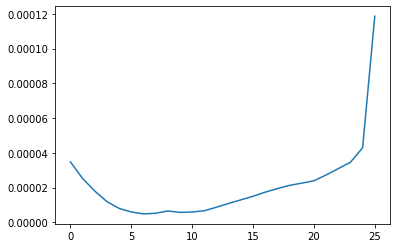

In [56]:
plt.plot(np.arange(26), evaluator.non_mae, label="MAE")

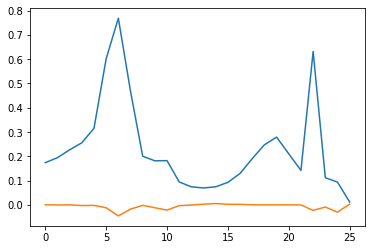

In [55]:
plt.plot(np.arange(26), evaluator.nmae, label="NMAE")
plt.plot(np.arange(26), R, label="R")